## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

We define the modified Stuart-Landau model as follows.

$$
\begin{aligned}
\dot{x} &= (x - I) - e^{I}y - [(x - I)^2 + (y)^2] (x-I) \\
\dot{y} &= y + e^{I} (x - I) - [(x - I)^2 + (y)^2] y
\end{aligned}
$$

where $x$ and $y$ are state variables and $I$ is the input to the system.
In this case, the stable periodic orbit when $I$ is fixed is as follows.
Where, $\theta \in [0, 2\pi)$ is a phase parameter that increases uniformly along the orbit.

$$
x_0(\theta,I) = \cos\theta + I, y_0(\theta, I) = \sin\theta \\
$$
If we define the phases as follows

$$
\Theta(x, y, I) = \tan^{-1}\frac{y}{x-I}
$$

The frequency and sensory function can be obtained as follows

$$
\omega(I) = e^{I}, \ \ \xi(\theta,I) = \sin\theta, \ \ \zeta(\theta,I) = e^I - \cos\theta
$$

If we assume that the input $I(t)$ fluctuates slowly enough compared to the amplitude decay of the oscillator, we obtain the generalized phase model as follows.

$$
\dot{\theta}(t) = \omega(I(t)) + \xi(\theta(t),I(t)) \dot{I}(t) \\
$$

Then, from the phase $\theta(t)$ of the generalized phase model, we can predict the state variables of the system as follows.

$$
x(t) \approx x_0(\theta(t),I(t)), \ \ y(t) \approx y_0(\theta(t),I(t))
$$

The conventional phase model can be obtained as follows

$$
\dot{\theta}(t) = \omega(0) + \zeta(\theta(t),0) I(t)
$$

The state variables can be predicted as follows.

$$
x(t) \approx x_0(\theta(t),0), \ \ y(t) \approx y_0(\theta(t),0)
$$

### Setup

In [1]:
using GeneralizedPhaseModel
using DifferentialEquations, ForwardDiff, PyPlot

Define the vector field of the system.

In [2]:
dxdt(X, I) = exp(2I)*(X[1]-X[2]-I)-((X[1]-I)^2+X[2]^2)*(X[1]-I)
dydt(X, I) = exp(2I)*(X[1]+X[2]-I)-((X[1]-I)^2+X[2]^2)*X[2]

F(X, I) = [dxdt(X, I), dydt(X, I)]

F (generic function with 1 method)

In [3]:
Imin = -1.2; Imax = 1.2; dI = 0.1
dt = 1e-3
D = 2
Nθ = 1000
Irange = Imin:dI:Imax
NI = size(Irange)[1]

dt = 1e-2
alg = Tsit5()

origin_val_idx = 2 
origin_thr = 0.0

# input
It(t, α=0.5) = α * (α * sin(0.3t) + cos(0.7t)^2)
dIdt(t) = ForwardDiff.derivative(t -> It(t), t)

trange = 0:dt:10pi
tspan = (0.0, trange[end])
Nt = size(trange)[1]

3142

The time variation of the input is shown below.

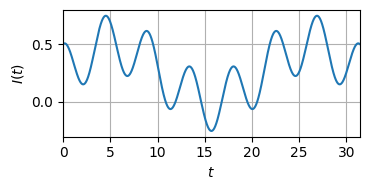

In [4]:
figure(figsize=(4, 2))
plot(trange, It.(trange))
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$I(t)$"); grid();
tight_layout()

Obtain the angular frequency $\omega(I)$, phase sensitivity function $\zeta(\theta, I), \xi(\theta, I)$, and the coordinates of stable periodic solution $X_s(I)$ for various inputs.

In [5]:
ωI, ζθI, ξθI, XsI = generalized_phase_sensitivity_func(F, Imin, Imax, dI, D, Nθ, nothing, 1e-4, alg, origin_val_idx, origin_thr);

[1/3] Computing Xs(θ, I) and Z(θ, I)...100%|████████████| Time: 0:01:38m39m


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


Plot the coordinates of the stable periodic solution to check if the simulation was stable.

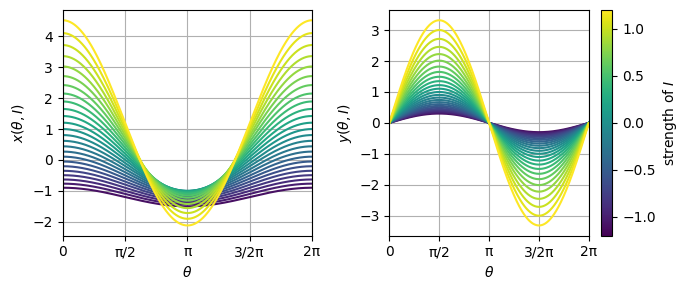

In [6]:
cmap = get_cmap("viridis")

figure(figsize=(7, 3))
θ = range(0, 2π, length=Nθ) 
subplot(1,2,1)
for i = 1:NI
    I = Irange[i]
    plot(θ, XsI[1](θ, I), color=cmap(i/NI))
end
xlim(0, 2pi); xticks([0, 0.5pi, pi, 1.5pi, 2pi], ["0", "π/2", "π", "3/2π", "2π"]);
grid(); xlabel(L"$\theta$"); ylabel(L"x(\theta, I)"); 

subplot(1,2,2)
for i = 1:size(Irange)[1]
    I = Irange[i]
    plot(θ, XsI[2](θ, I), color=cmap(i/NI))
end
xlim(0, 2pi); xticks([0, 0.5pi, pi, 1.5pi, 2pi], ["0", "π/2", "π", "3/2π", "2π"]);
grid(); xlabel(L"$\theta$"); ylabel(L"y(\theta, I)"); 

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=Imin, vmax=Imax))
plt.colorbar(sm, label=L"strength of $I$")

tight_layout()

### Original system
Run a simulation of the original system.

In [7]:
function os_updateX(X, I, t)
    return F(X, I(t))
end

os_updateX (generic function with 1 method)

In [8]:
initX = [1.0, 0.0]

integrator_os = get_ode_integrator(os_updateX, initX, dt, It, alg)
Xos = zeros(Nt, D)

@time for tt in 1:Nt
    Xos[tt, :] = integrator_os.u # memory
    step!(integrator_os, dt, true)
end

"""
sol_os = get_ode_solution(os_updateX, initX, tspan, dt, It, alg)
println(sol_os.retcode)
"""

  0.447914 seconds (1.25 M allocations: 77.892 MiB, 97.87% compilation time)


"sol_os = get_ode_solution(os_updateX, initX, tspan, dt, It, alg)\nprintln(sol_os.retcode)\n"

### Conventional phase model

In [9]:
function conventinal_updateθ(θ, p, t)
    I, ωI, ζθI = p
    return ωI(0) + ζθI(mod(θ, 2π), 0) * I(t)
end

conventinal_updateθ (generic function with 1 method)

In [10]:
initθcpm = 0.0

integrator_cpm = get_ode_integrator(conventinal_updateθ, initθcpm, dt, [It, ωI, ζθI], alg)

Xcpm = zeros(Nt, D)
Θcpm = zeros(Nt)

@time for tt in 1:Nt
    Θcpm[tt] = mod(integrator_cpm.u, 2π)
    Xcpm[tt, :] = [XsI[i](Θcpm[tt], It(integrator_cpm.t)) for i in 1:D] # memory
    step!(integrator_cpm, dt, true)
end

  0.489909 seconds (1.52 M allocations: 70.662 MiB, 95.12% compilation time)


In [11]:
"""
sol_cpm = get_ode_solution(conventinal_updateθ, initθcpm, tspan, dt, [It, ωI, ζθI], alg)
println(sol_cpm.retcode)

Xcpm = zeros(size(sol_cpm.t)[1], D)
for i in 1:D
    Xcpm[:, i] = XsI[i].(mod.(sol_cpm.u, 2π), It.(sol_cpm.t)) # memory
end
"""

"sol_cpm = get_ode_solution(conventinal_updateθ, initθcpm, tspan, dt, [It, ωI, ζθI], alg)\nprintln(sol_cpm.retcode)\n\nXcpm = zeros(size(sol_cpm.t)[1], D)\nfor i in 1:D\n    Xcpm[:, i] = XsI[i].(mod.(sol_cpm.u, 2π), It.(sol_cpm.t)) # memory\nend\n"

### Generalized phase model

In [12]:
function generalized_updateθ(θ, p, t)
    I, dIdt, ωI, ξθI = p
    return ωI(I(t)) + ξθI(mod(θ, 2π), I(t)) * dIdt(t)
end

generalized_updateθ (generic function with 1 method)

In [13]:
Xgpm = zeros(Nt, D)
Θgpm = zeros(Nt)
initθgpm = 0.0
integrator_gpm = get_ode_integrator(generalized_updateθ, initθgpm, dt, [It, dIdt, ωI, ξθI], alg)

@time for tt in 1:Nt    
    Θgpm[tt] = mod(integrator_gpm.u, 2π)
    Xgpm[tt, :] = [XsI[i](Θgpm[tt], It(integrator_gpm.t)) for i in 1:D] # memory
    step!(integrator_gpm, dt, true)
end

  0.452311 seconds (1.46 M allocations: 64.408 MiB, 93.74% compilation time)


In [14]:
"""
sol_gpm = get_ode_solution(generalized_updateθ, initθgpm, tspan, dt, [It, dIdt, ωI, ξθI], alg)
println(sol_gpm.retcode)

Xgpm = zeros(size(sol_gpm.t)[1], D)
for i in 1:D
    Xgpm[:, i] = XsI[i].(mod.(sol_gpm.u, 2π), It.(sol_gpm.t)) # memory
end
"""

"sol_gpm = get_ode_solution(generalized_updateθ, initθgpm, tspan, dt, [It, dIdt, ωI, ξθI], alg)\nprintln(sol_gpm.retcode)\n\nXgpm = zeros(size(sol_gpm.t)[1], D)\nfor i in 1:D\n    Xgpm[:, i] = XsI[i].(mod.(sol_gpm.u, 2π), It.(sol_gpm.t)) # memory\nend\n"

### Results

Plot the phase change.

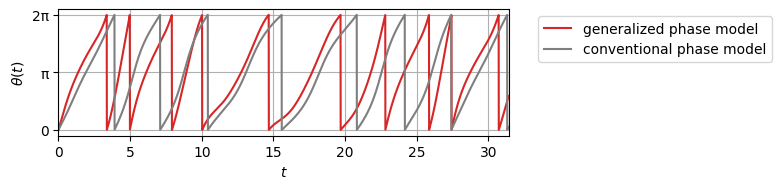

In [15]:
figure(figsize=(8, 2))
plot(trange, Θgpm, color="tab:red", label="generalized phase model")
plot(trange, Θcpm, color="tab:gray", label="conventional phase model")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$θ(t)$"); grid(); 
yticks([0, pi, 2pi], ["0", "π", "2π"]);
legend(loc="upper left", bbox_to_anchor=(1.05, 1))
tight_layout()

Plot the approximate predictions of conventional and generalized phase models for the dynamics of the original system. Below is the difference between the original system dynamics and the phase model predictions.

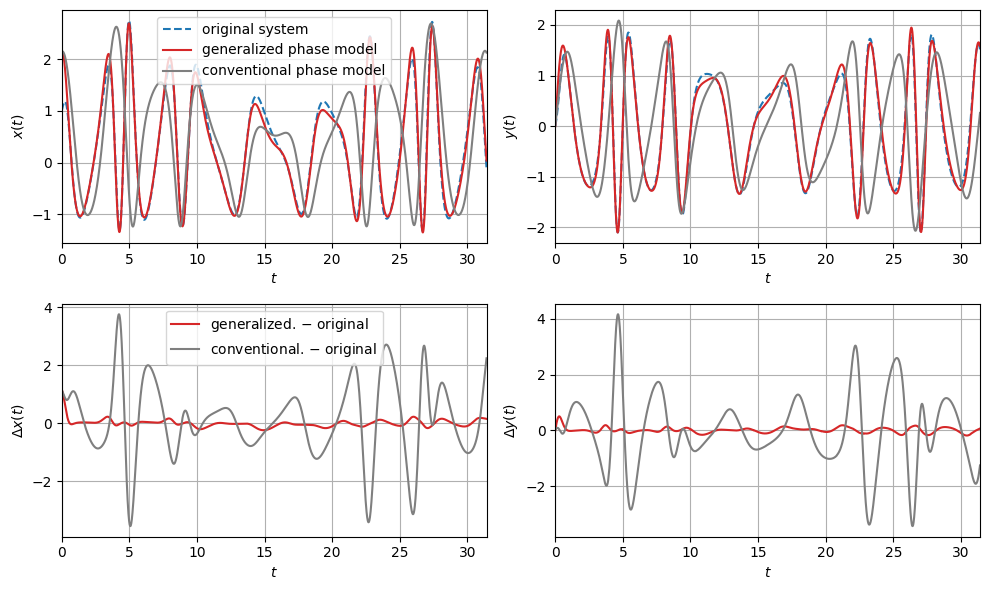

In [16]:
figure(figsize=(10, 6))
subplot(2,2,1)
plot(trange, Xos[:, 1], "--", label="original system")
plot(trange, Xgpm[:, 1], color="tab:red", label="generalized phase model")
plot(trange, Xcpm[:, 1], color="tab:gray", label="conventional phase model")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$x(t)$"); grid(); legend()

subplot(2,2,2)
plot(trange, Xos[:, 2], "--", label="original system")
plot(trange, Xgpm[:, 2], color="tab:red", label="generalized phase model")
plot(trange, Xcpm[:, 2], color="tab:gray", label="conventional phase model")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$y(t)$"); grid()

subplot(2,2,3)
plot(trange, Xgpm[:, 1]-Xos[:, 1], color="tab:red", label=L"generalized. $-$ original")
plot(trange, Xcpm[:, 1]-Xos[:, 1], color="tab:gray", label=L"conventional. $-$ original")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$\Delta x(t)$"); grid(); legend()

subplot(2,2,4)
plot(trange, Xgpm[:, 2]-Xos[:, 2], color="tab:red")
plot(trange, Xcpm[:, 2]-Xos[:, 2], color="tab:gray")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$\Delta y(t)$"); grid()

tight_layout()

Note : As the input increases in the negative direction (< -0.5), the prediction accuracy decreases.